#Чтение данных

In [1]:
!pip install pymorphy2==0.9.1

     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 8.2 MB 14.0 MB/s 


In [2]:
import re
import pandas as pd
import numpy as np
import pymorphy2
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/avito-search-intern/MisspellsTestCase/main/data/dataset.tsv', 
                 sep='\t', keep_default_na=False)

holdout = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/avito-search-intern/MisspellsTestCase/main/data/holdout.tsv',
                      sep='\t', keep_default_na=False)

In [4]:
df.head()

,INPUT:diff1,INPUT:diff2,INPUT:query1,INPUT:query2,OUTPUT:result,CONFIDENCE:result
0,магнитагорск,магнитогорске,авито магнитагорск строительные леса в аренду,авито магнитогорске строительные леса в аренду,no,99.99%
1,магнитки,магнит,50 лет магнитки 31,50 лет магнит 31,no,98.74%
2,loriblue,loriblu,loriblue туфли,loriblu туфли,yes,99.57%
3,kfr,лак,gree kfr,gree лак,yes,82.09%
4,амартизаторы,амортизатор,амартизаторы ман,амортизатор ман,yes,99.99%


Проверим размер, типы столбцов, наличие нулевых элементов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   INPUT:diff1        7845 non-null   object
 1   INPUT:diff2        7845 non-null   object
 2   INPUT:query1       7845 non-null   object
 3   INPUT:query2       7845 non-null   object
 4   OUTPUT:result      7845 non-null   object
 5   CONFIDENCE:result  7845 non-null   object
dtypes: object(6)
memory usage: 367.9+ KB


Заменим yes/no на 1/0

In [6]:
df['OUTPUT:result'] = df['OUTPUT:result'].apply(lambda x: 1 if x == 'yes' else 0)
df['CONFIDENCE:result'] = df['CONFIDENCE:result'].apply(lambda x: float(x[:-1]) / 100) 

Уберем из выборки одинаковые неисправленные запросы

In [7]:
df = df.drop_duplicates(subset=['INPUT:query1'])

In [8]:
df.shape

(7844, 6)

In [9]:
df['OUTPUT:result'].value_counts(normalize=True)

0    0.509816
1    0.490184
Name: OUTPUT:result, dtype: float64

In [10]:
chars_sub = '[!|?|.|-|_|\|#|@]'

df['INPUT:query1'] = df['INPUT:query1'].apply(lambda x: re.sub(chars_sub, ' ', x))
df['INPUT:query2'] = df['INPUT:query2'].apply(lambda x: re.sub(chars_sub, ' ', x))
holdout['INPUT:query1'] = holdout['INPUT:query1'].apply(lambda x: re.sub(chars_sub, ' ', x))
holdout['INPUT:query2'] = holdout['INPUT:query2'].apply(lambda x: re.sub(chars_sub, ' ', x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
char_tokenizer = Tokenizer(char_level=True)

char_tokenizer.fit_on_texts(df['INPUT:diff1'].tolist() + df['INPUT:diff2'].tolist() + holdout['INPUT:diff1'].tolist() + holdout['INPUT:diff2'].tolist())

print("Vocab size: ", len(char_tokenizer.word_index) + 1)

Vocab size:  66


In [12]:
tokenizer = Tokenizer(char_level=False)

tokenizer.fit_on_texts(df['INPUT:query1'].tolist() + df['INPUT:query2'].tolist() + holdout['INPUT:query1'].tolist() + holdout['INPUT:query2'].tolist())

print("Vocab size: ", len(tokenizer.word_index) + 1)

Vocab size:  13251


In [13]:
training_y = df['OUTPUT:result'].reset_index(drop=True)

In [14]:
word_a = pad_sequences(char_tokenizer.texts_to_sequences(df['INPUT:diff1']), maxlen=20)
word_b = pad_sequences(char_tokenizer.texts_to_sequences(df['INPUT:diff2']), maxlen=20)

In [15]:
sent_a = pad_sequences(tokenizer.texts_to_sequences(df['INPUT:query1']), maxlen=20)
sent_b = pad_sequences(tokenizer.texts_to_sequences(df['INPUT:query2']), maxlen=20)

#Обучение модели

In [28]:
diff1 = Input(shape=(20, ), name='diff1')  
diff2 = Input(shape=(20, ), name="diff2")
query1 = Input(shape=(20, ), name="query1")
query2 = Input(shape=(20, ), name="query2")

diff_layer = layers.concatenate([diff1, diff2])
query_layer = layers.concatenate([query1, query2])

embed_layer_diff = Embedding(len(char_tokenizer.word_index) + 1, 8)(diff_layer)
embed_layer_query = Embedding(len(tokenizer.word_index) + 1, 32)(query_layer)

conv_diff = Conv1D(8, 16, activation='relu')(embed_layer_diff)
conv_query = Conv1D(32, 16, activation='relu')(embed_layer_query)

#concate_layer = layers.concatenate([conv_diff, conv_query])

lstm_1 = LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True, name='first')(conv_diff)

lstm_2 = LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True, name='second')(conv_query)

concate_layer = layers.concatenate([lstm_1, lstm_2])

lstm_3 = LSTM(64, dropout=0.2, recurrent_dropout=0.2, activation="relu", name='last')(concate_layer)

title_features = Dense(32, activation='relu')(lstm_3)

priority_pred = Dense(1, name="result", activation='sigmoid')(title_features)

model = keras.Model(
    inputs=[diff1, diff2, query1, query2],
    outputs=[priority_pred],
)

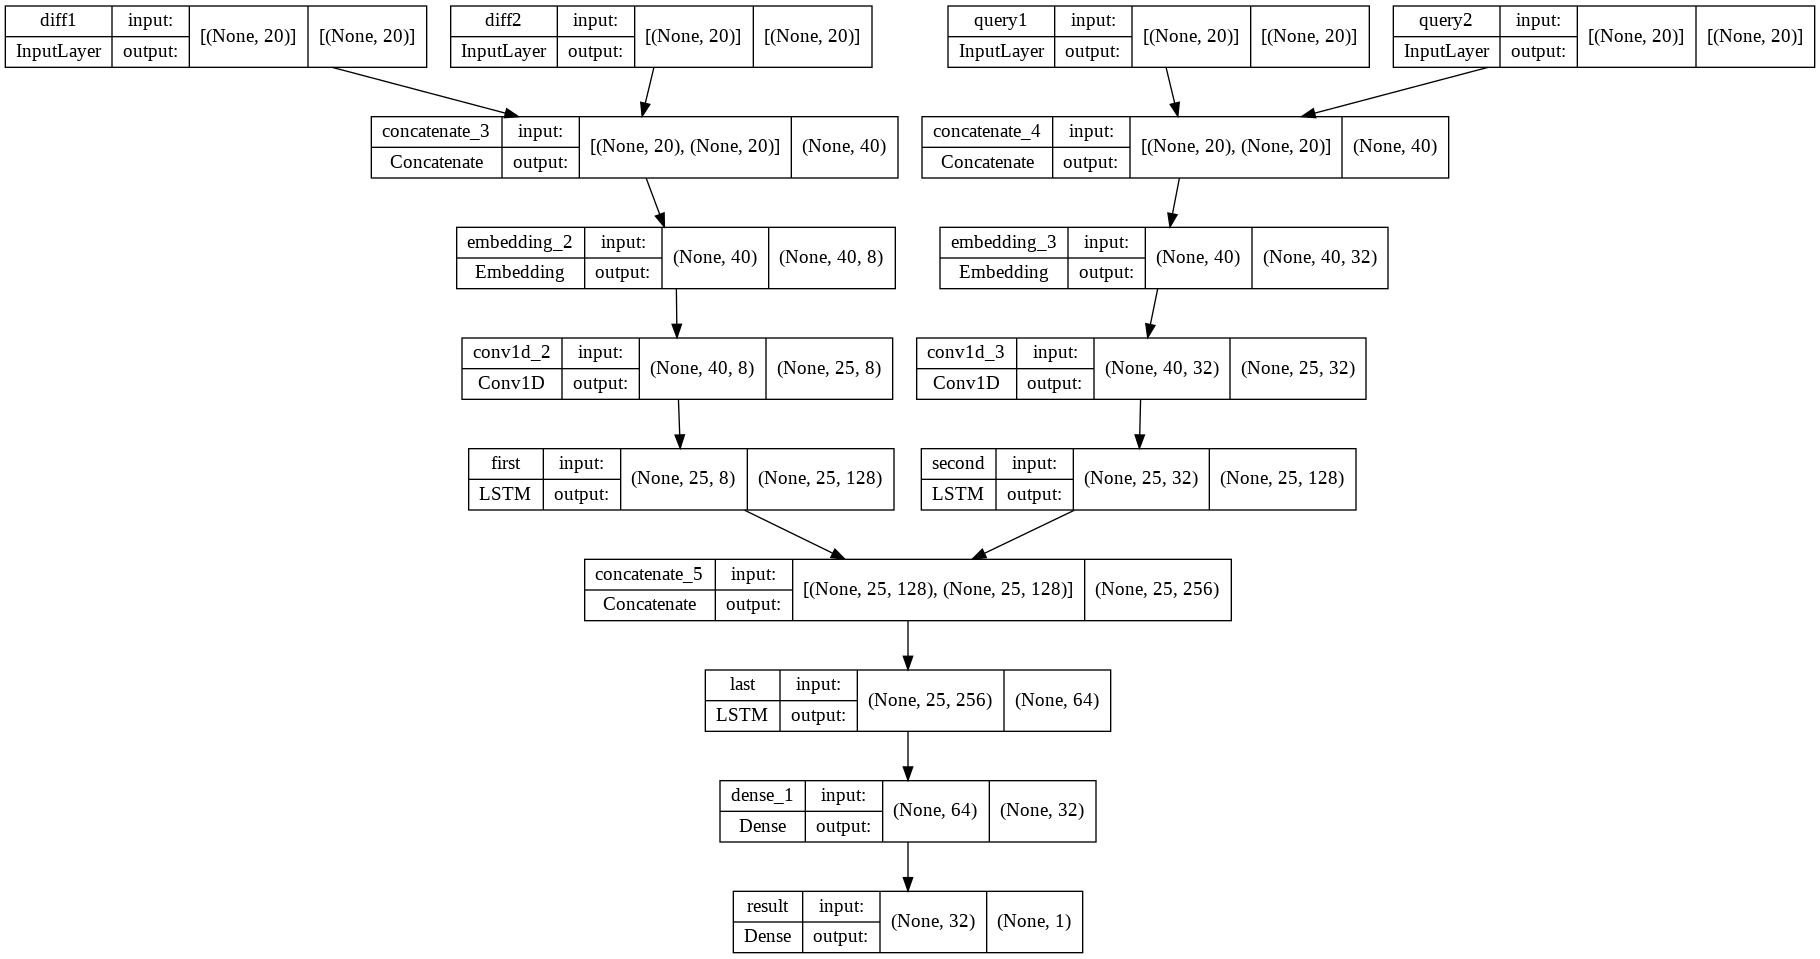

In [29]:
plot_model(model, show_shapes=True)

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [31]:
model_checkpoint = ModelCheckpoint(
    filepath='/',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [32]:
history = model.fit(
    {"diff1": word_a, "diff2": word_b, 'query1': sent_a, 'query2': sent_b}, {"result": training_y},
    epochs=15,
    batch_size=256,
    validation_split=0.05,
    shuffle=True,
    callbacks=[model_checkpoint]
)

Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 0.6881 - binary_accuracy: 0.5763INFO:tensorflow:Assets written to: /assets


INFO:tensorflow:Assets written to: /assets


30/30 [==============================] - 35s 924ms/step - loss: 0.6881 - binary_accuracy: 0.5763 - val_loss: 0.6499 - val_binary_accuracy: 0.6438
Epoch 2/15
30/30 [==============================] - ETA: 0s - loss: 0.6329 - binary_accuracy: 0.6524INFO:tensorflow:Assets written to: /assets


INFO:tensorflow:Assets written to: /assets


30/30 [==============================] - 26s 874ms/step - loss: 0.6329 - binary_accuracy: 0.6524 - val_loss: 0.5874 - val_binary_accuracy: 0.7048
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.6036 - binary_accuracy: 0.6831INFO:tensorflow:Assets written to: /assets


INFO:tensorflow:Assets written to: /assets


30/30 [==============================] - 27s 905ms/step - loss: 0.6036 - binary_accuracy: 0.6831 - val_loss: 0.5696 - val_binary_accuracy: 0.7277
Epoch 4/15
30/30 [==============================] - ETA: 0s - loss: 0.5653 - binary_accuracy: 0.7360INFO:tensorflow:Assets written to: /assets


INFO:tensorflow:Assets written to: /assets


30/30 [==============================] - 26s 869ms/step - loss: 0.5653 - binary_accuracy: 0.7360 - val_loss: 0.5919 - val_binary_accuracy: 0.7405
Epoch 5/15
30/30 [==============================] - 17s 549ms/step - loss: 0.3717 - binary_accuracy: 0.8640 - val_loss: 0.6348 - val_binary_accuracy: 0.7099
Epoch 6/15
30/30 [==============================] - 17s 554ms/step - loss: 0.1902 - binary_accuracy: 0.9330 - val_loss: 0.8805 - val_binary_accuracy: 0.7201
Epoch 7/15
30/30 [==============================] - 17s 565ms/step - loss: 0.1159 - binary_accuracy: 0.9600 - val_loss: 1.1520 - val_binary_accuracy: 0.6768
Epoch 8/15
30/30 [==============================] - 17s 561ms/step - loss: 0.0798 - binary_accuracy: 0.9707 - val_loss: 1.6997 - val_binary_accuracy: 0.6845
Epoch 9/15
30/30 [==============================] - 17s 553ms/step - loss: 0.0570 - binary_accuracy: 0.9797 - val_loss: 2.1845 - val_binary_accuracy: 0.7023
Epoch 10/15
30/30 [==============================] - 17s 552ms/step -

#Валидация

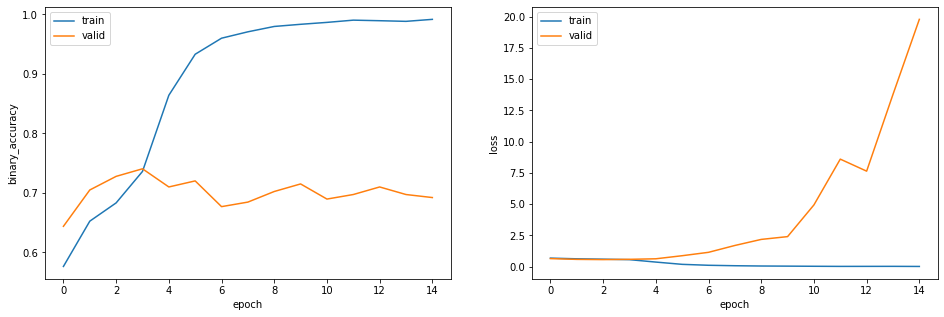

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['binary_accuracy'], label='train')
axs[0].plot(history.history['val_binary_accuracy'], label='valid')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('binary_accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='valid')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].legend()

fig.show()

#Применяем на отложенной выборке

In [34]:
morph = pymorphy2.MorphAnalyzer()

In [35]:
word_a_holdout = pad_sequences(char_tokenizer.texts_to_sequences(holdout['INPUT:diff1']), maxlen=20)
word_b_holdout = pad_sequences(char_tokenizer.texts_to_sequences(holdout['INPUT:diff2']), maxlen=20)

sent_a_holdout = pad_sequences(tokenizer.texts_to_sequences(holdout['INPUT:query1']), maxlen=20)
sent_b_holdout = pad_sequences(tokenizer.texts_to_sequences(holdout['INPUT:query2']), maxlen=20)

исопльзуем лучшую сохраненную модель из model_chekpoint и morph анализатор для проверки орфографии

In [36]:
morph_chek = [-0.1 if morph.word_is_known(i) else 0.45 for i in holdout['INPUT:diff1']]

prediction = model_checkpoint.model.predict({'diff1': word_a_holdout, 'diff2': word_b_holdout, 'query1': sent_a_holdout, 'query2': sent_b_holdout})
prediction_with_morph = [prediction[i][0] + morph_chek[i] if prediction[i][0] + morph_chek[i] > 0 and prediction[i][0] + morph_chek[i] < 1 else prediction[i][0] 
                         for i in range(prediction.shape[0])]

In [37]:
holdout['OUTPUT:result'] = ['yes' if i >= 0.5 else 'no' for i in prediction]
holdout['OUTPUT:score'] = [i if i >= 0.5 else 1.0 - i for i in prediction]

In [26]:
holdout.to_csv('sample_submission.tsv', '\t', index=False)